# Introduction to vector databases on S&P 500 news

 # 📌 Objectives
 
 By the end of this notebook, students will be able to:
 
 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.
 
 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.
 
 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.
 
 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.
 
 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.
 
 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.
 
 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [1]:
# %pip install sentence-transformers
# %pip install faiss-cpu

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [52]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss
import yfinance as yf

## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [2]:
df_news = pd.read_csv('../data/df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:
 
### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.
 
### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):
 
 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).
 
 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.
 
You will test your class at the end.

In [3]:
# Create the EMBEDDED_TEXT column

df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' ' + df_news['SUMMARY']

display(df_news.head())

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,EMBEDDED_TEXT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,2 Dow Jones Stocks with Promising Prospects an...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,3 S&P 500 Stocks Skating on Thin Ice The S&P 5...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,3M Rises 15.8% YTD: Should You Buy the Stock N...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...,3 Cash-Producing Stocks with Questionable Fund...


In [ ]:
# Load the embedding model

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [19]:
class CustomVectorStore:
    def __init__(self,
                 embedding_model: SentenceTransformer,
                 documents: list[str],
                 metadata: list[dict[str, str]]):
        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata

        if len(documents) != len(metadata):
            raise ValueError("Number of documents must match number of metadata entries.")

        self.embeddings = self.embedding_model.encode(documents)

    def search(self,
               query: str,
               k: int = 5,
               metadata_filter: dict[str, str] = None):

        mask = self._filter_to_mask(metadata_filter)

        similarities = cosine_similarity(
            self.embedding_model.encode([query]),
            np.array(self._masked(self.embeddings, mask))
        )[0]

        result = (
            (d, m, s) for d, m, s in zip(
                self._masked(self.documents, mask),
                self._masked(self.metadata, mask),
                similarities
            )
        )

        # Sort by similarity (third item) desc, return top k results
        return sorted(result, key = lambda x: x[2], reverse=True)[:k]

    def _filter_to_mask(self, metadata_filter):
        if metadata_filter is None:
            return [True for _ in self.metadata]

        return [
            self._is_metadata_match(self.metadata[i], metadata_filter) for i in range(len(self.metadata))
        ]

    @staticmethod
    def _is_metadata_match(document_metadata, metadata_filter):
        for key, value in metadata_filter.items():
            if key not in document_metadata or document_metadata[key] != value:
                return False
        return True

    @staticmethod
    def _masked(items, mask):
        return (item for i, item in enumerate(items) if mask[i])


In [5]:
# CODE HERE
# Use as many coding cells as you need

In [8]:
documents = df_news['EMBEDDED_TEXT'].tolist()

display(documents[:5])  # Display first 5 documents to verify

['2 Dow Jones Stocks with Promising Prospects and 1 to Avoid The Dow Jones (^DJI) is made up of 30 of the most established and influential companies in the market. But even blue-chip stocks can struggle - some are dealing with slowing growth, outdated business models, or increasing competition.',
 '3 S&P 500 Stocks Skating on Thin Ice The S&P 500 (^GSPC) is often seen as a benchmark for strong businesses, but that doesn’t mean every stock is worth owning. Some companies face significant challenges, whether it’s stagnating growth, heavy debt, or disruptive new competitors.',
 '3M Rises 15.8% YTD: Should You Buy the Stock Now or Wait? MMM is making strides in the aerospace, industrial adhesives and tapes, and electrical markets, which makes the stock worth a watch amid certain headwinds.',
 'Q1 Earnings Roundup: 3M (NYSE:MMM) And The Rest Of The General Industrial Machinery Segment Quarterly earnings results are a good time to check in on a company’s progress, especially compared to its 

In [9]:
metadata = []

for row in df_news.itertuples():
    metadata.append({
        'PUBLICATION_DATE': row.PUBLICATION_DATE,
        'TICKER': row.TICKER,
        'PROVIDER': row.PROVIDER
    })

display(metadata[:5])  # Display first 5 metadata entries to verify

[{'PUBLICATION_DATE': datetime.date(2025, 5, 29),
  'TICKER': 'MMM',
  'PROVIDER': 'StockStory'},
 {'PUBLICATION_DATE': datetime.date(2025, 5, 27),
  'TICKER': 'MMM',
  'PROVIDER': 'StockStory'},
 {'PUBLICATION_DATE': datetime.date(2025, 5, 22),
  'TICKER': 'MMM',
  'PROVIDER': 'Zacks'},
 {'PUBLICATION_DATE': datetime.date(2025, 5, 22),
  'TICKER': 'MMM',
  'PROVIDER': 'StockStory'},
 {'PUBLICATION_DATE': datetime.date(2025, 5, 19),
  'TICKER': 'MMM',
  'PROVIDER': 'StockStory'}]

In [22]:
vector_store = CustomVectorStore(
    embedding_model=embedding_model,
    documents=documents,
    metadata=metadata
)

In [23]:
vector_store.search("Apple earnings", k=3)  # Test the search method

[('Aptiv Stock Rises. Earnings Were Great, But Tariff Impact Is Still Uncertain. Thursday morning, Aptiv reported first-quarter earnings per share of $1.69 from sales of $4.8 billion in sales. Wall Street was looking for EPS of $1.53 from sales of $4.8 billion.',
  {'PUBLICATION_DATE': datetime.date(2025, 5, 1),
   'TICKER': 'APTV',
   'PROVIDER': 'Barrons.com'},
  np.float32(0.5717155)),
 ('ONEOK (NYSE:OKE) Reports Q1 2025 Revenue Surge to US$8 Billion ONEOK (NYSE:OKE) recently released its first-quarter earnings, reporting revenue of USD 8,043 million, a marked increase year-over-year, but a minor dip in net income and earnings per share. Alongside this, the company reaffirmed its quarterly dividend of $1.03 per share. These updates coincide with a 4.5% price increase over the week, which aligns with broader market gains of 5.2%. Despite fluctuations in major indices due to economic data and earnings reports from numerous companies,...',
  {'PUBLICATION_DATE': datetime.date(2025, 4, 

### Retrieve AI Announcements
 
 Now that your vector store is working, let's use it to retrieve relevant documents.
 
 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text
 

In [6]:
# CODE HERE
# Use as many coding cells as you need

In [46]:
results = vector_store.search("AI announcement", k=50)

for doc, meta, similarity in results:
    print("="*64)
    print(f"{meta['TICKER']:<6} | {meta['PUBLICATION_DATE']} | {meta['PROVIDER']}")
    print(f"Similarity: {similarity:.4f}")
    print("-"*64)
    print(doc)
    print("="*64)
    print("\n\n")

ADBE   | 2025-05-27 | Investor's Business Daily
Similarity: 0.5567
----------------------------------------------------------------
AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.



JKHY   | 2025-03-17 | Insider Monkey
Similarity: 0.5467
----------------------------------------------------------------
Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]



PLTR   | 2025-05-31 | Motley Fool
Similarity: 0.5353
----------------------------------------------------------------
Better Artific

In [7]:
# CODE HERE
# Use as many coding cells as you need

In [53]:
count_by_ticker = {}

for _, meta, _ in results:
    t = meta['TICKER']

    if t in count_by_ticker:
        count_by_ticker[t] += 1

    else:
        count_by_ticker[t] = 1

sorted_tickers_count = sorted(count_by_ticker.items(), key=lambda x: x[1], reverse=True)

In [54]:
# Focusing analysis on tickers appearing more than once
filtered_tickers = [(t, c) for t, c in sorted_tickers_count if c > 1]

In [81]:
for t, c in filtered_tickers:
    comp_name = yf.Ticker(t).info['longName']
    print(f"{comp_name} [{t}] appeared in {c} articles about 'AI announcement'")

Palantir Technologies Inc. [PLTR] appeared in 5 articles about 'AI announcement'
Baker Hughes Company [BKR] appeared in 3 articles about 'AI announcement'
Advanced Micro Devices, Inc. [AMD] appeared in 3 articles about 'AI announcement'
Cognizant Technology Solutions Corporation [CTSH] appeared in 3 articles about 'AI announcement'
QUALCOMM Incorporated [QCOM] appeared in 2 articles about 'AI announcement'
Meta Platforms, Inc. [META] appeared in 2 articles about 'AI announcement'
Amazon.com, Inc. [AMZN] appeared in 2 articles about 'AI announcement'
Microsoft Corporation [MSFT] appeared in 2 articles about 'AI announcement'
Expedia Group, Inc. [EXPE] appeared in 2 articles about 'AI announcement'
Intel Corporation [INTC] appeared in 2 articles about 'AI announcement'


Announcements from chipmakers (Intel, AMD, Qualcomm) are to be expected since they are developing new chips with AI accelerators.

Microsoft and Amazon were also expected, since they provide the cloud computing services to execute AI workloads, and both of them are introducing AI heavily on their core products. Meta is a similar story; while they don't provide cloud services, they are integrating AI in all their applications, and they are also heavily invested in the development of LLMs.

Palantir is the company with the most appearances, and while I may not be that familiar with the company, I do know that they operate in the military sector, which involves a lot of government contracts as well.

Baker Hughes and Expedia may not be the first companies the general population thinks about when talking about AI; however, it makes sense to see them in the list since they are starting to adopt AI technologies.

Lastly, Cognizant is a consulting company, and that industry is currently investing very heavily in implementing AI solutions for partners and customers.
 

In [8]:
# CODE HERE
# Use as many coding cells as you need

In [113]:
count_by_date = {}

for _, meta, _ in results:
    _date = meta['PUBLICATION_DATE']

    if _date in count_by_date:
        count_by_date[_date] += 1

    else:
        count_by_date[_date] = 1

In [114]:
print(f"Date ranges from {min(count_by_date.keys())} to {max(count_by_date.keys())}")

Date ranges from 2025-03-17 to 2025-05-31


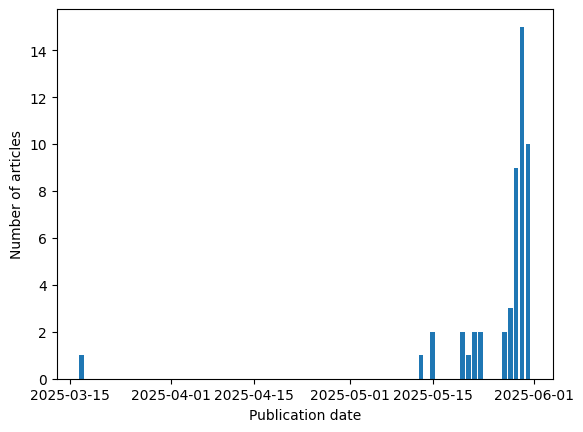

In [115]:
plt.bar(count_by_date.keys(), count_by_date.values())
plt.xlabel('Publication date')
plt.ylabel('Number of articles')
plt.show()

Articles about AI announcements are not evenly distributed across time. In fact, they are mostly clustered in the second half of May, 2025.

In [9]:
# CODE HERE
# Use as many coding cells as you need

We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

In [10]:
# CODE HERE
# Use as many coding cells as you need

### Create a `FaissVectorStore` class with a `.search()` method.
 
 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata 

In [11]:
# CODE HERE
# Use as many coding cells as you need

 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`
 
 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text 

In [12]:
# CODE HERE
# Use as many coding cells as you need

## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:
 
 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [13]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation', 
    'Cryptocurrency'

]

In [14]:
# CODE HERE
# Use as many coding cells as you need

### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

YOUR WRITTEN RESPONSE HERE
 

## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:
 
 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [15]:
# CODE HERE
# Use as many coding cells as you need

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

 YOUR WRITTEN RESPONSE HERE

## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?


 YOUR WRITTEN RESPONSE HERE
 


### **Q6.**  What would happen if vectors were not normalized before indexing?


 YOUR WRITTEN RESPONSE HERE
 
 


## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?



 YOUR WRITTEN RESPONSE HERE
 



### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.


 YOUR WRITTEN RESPONSE HERE
 